# Ordinal regression task

In [41]:
import re
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import datetime

import warnings
warnings.filterwarnings("ignore")

from sklearn import tree
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error,r2_score

from math import sqrt
from scipy import stats 

In [42]:
df = pd.read_csv("data_cleaned.csv")
df.head(2)

,App,Rating,Reviews,Size,Installs,Price,Content Rating,Last Updated,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores
0,🔥 FOOTBALL WALLPAPERS 4K | FULL HD BACKGROUNDS 😍,4.7,11661,4.0,"(1000000, 5000000]",0.0,Everyone,07-2018,1.1.3.2,4.0.3 and up,Entertainment,None,0,0,Medium,0.002914,0
1,📏 SMART RULER ↔️ CM/INCH MEASURING FOR HOMEWORK!,4.0,19,3.2,"(10000, 50000]",0.0,Everyone,10-2017,1.0,4.2 and up,Tools,None,0,0,Medium,0.000473,0


In [43]:
df.shape

(8197, 17)

## Decision Tree regressor (DTR)

### Preprocessing

- Features encoding

In [44]:
from sklearn.preprocessing import LabelEncoder

In [45]:
#Categorical encoding

label_encoders = dict()
column2encode = ['Content Rating', 'Current Ver', 'Installs', 'Android Ver', 'Secondary_Genres', 'Compatibility', 'Main_Genres']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [46]:
#App name drop

df.drop('App', axis=1, inplace=True)

In [47]:
#Last Updated encoding

df['YearUpdated'], df['MonthUpdated'] = pd.to_datetime(df['Last Updated']).dt.year, pd.to_datetime(df['Last Updated']).dt.month
df.drop('Last Updated', axis=1, inplace=True)

In [48]:
df[(df['Rating']==1.2)]

,Rating,Reviews,Size,Installs,Price,Content Rating,Current Ver,Android Ver,Main_Genres,Secondary_Genres,Is_Family,Is_Game,Compatibility,RTR,Both_Stores,YearUpdated,MonthUpdated
5149,1.2,44,27.0,3,0.0,1,1579,25,19,5,0,0,2,0.010998,0,2018,4


In [49]:
df.drop(df[(df['Rating']==1.2)].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [50]:
df_copy = df.copy()

### Perform DTR

- Features selection and model construction

In [11]:
features = [col for col in df.columns if col != 'Rating']
X = df[features].values

X = df[features]
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

In [12]:
clf = tree.DecisionTreeRegressor(criterion='mse', 
                                 max_depth=6, 
                                 min_samples_split=2, 
                                 min_samples_leaf=5,
                                 random_state=42)
clf = clf.fit(X_train, y_train)

In [13]:
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=5, random_state=42)

In [14]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

### Analyze the results

- Features importance

{'Secondary_Genres': 0.0, 'Is_Game': 0.0, 'Compatibility': 0.0, 'Both_Stores': 0.0, 'Is_Family': 0.005596454576268625, 'Current Ver': 0.010170970321460176, 'Content Rating': 0.011413566913913162, 'Installs': 0.018302428888721536, 'MonthUpdated': 0.02107251250687544, 'Price': 0.026577605969373978, 'Main_Genres': 0.03880944650932835, 'YearUpdated': 0.057298831554201894, 'Size': 0.057758934563247454, 'Android Ver': 0.08794711310115842, 'Reviews': 0.19394891004094594, 'RTR': 0.47110322505450497}


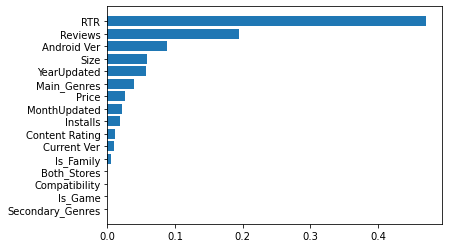

In [15]:
import matplotlib.pyplot as plt
from collections import OrderedDict

d={}
labels = []
sizes = []
for col, imp in zip(features, clf.feature_importances_):
    d[col]=imp

sort_d= {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
print(sort_d)

#Plot
plt.barh(*zip(*sort_d.items()))
plt.show()

- Evaluate the performance

In [16]:
print('MAE of TEST %s' %
      metrics.mean_absolute_error(y_test, y_pred))
print('\nMSE of TEST %s' %
      metrics.mean_squared_error(y_test, y_pred))
print('\nRMSE of TEST %s' %
      sqrt(mean_squared_error(y_test, y_pred)))

pearson_coef= stats.pearsonr(y_test, y_pred)
print("\nr TEST", pearson_coef[0])

ks= stats.ks_2samp(y_test, y_pred, alternative='two-sided', mode='auto')
print('\nKS TEST', ks[0])

MAE of TEST 0.3445199999556061

MSE of TEST 0.2577355333345405

RMSE of TEST 0.5076766030993949

r TEST 0.34120984947274746

KS TEST 0.2659617730784872


### Hyper-parameters tuning

In [17]:
from sklearn import linear_model, metrics, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [18]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [19]:
param_list = {"criterion": ["mse", "mae"],
              "min_samples_split": [2, 3, 4, 5, 6, 10, 20],
              "max_depth": [2, 5, 6, 10, 20, 50, 100],
              "min_samples_leaf": [5, 8, 10, 20, 30, 50, 100, 200],
              }, 

grid_search = GridSearchCV(clf, param_grid=param_list, cv=5, n_jobs=1)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_, n_top=3)

Mean validation score: 0.13141 (std: 0.01181)
Parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 200, 'min_samples_split': 2}

Mean validation score: 0.13141 (std: 0.01181)
Parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 200, 'min_samples_split': 3}

Mean validation score: 0.13141 (std: 0.01181)
Parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 200, 'min_samples_split': 4}

Mean validation score: 0.13141 (std: 0.01181)
Parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 200, 'min_samples_split': 5}

Mean validation score: 0.13141 (std: 0.01181)
Parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 200, 'min_samples_split': 6}

Mean validation score: 0.13141 (std: 0.01181)
Parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 200, 'min_samples_split': 10}

Mean validation score: 0.13141 (std: 0.01181)
Parameters: {'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 200, 'm

In [20]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=200, random_state=42)

### Perform best estimator and analyze the results

In [21]:
clf = grid_search.best_estimator_

y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

- Features importance

{'Installs': 0.0, 'Price': 0.0, 'Content Rating': 0.0, 'Secondary_Genres': 0.0, 'Is_Family': 0.0, 'Is_Game': 0.0, 'Compatibility': 0.0, 'Both_Stores': 0.0, 'MonthUpdated': 0.0, 'Size': 0.01323421284807424, 'Current Ver': 0.018410494598196474, 'Android Ver': 0.038340753111784524, 'YearUpdated': 0.04860387049751545, 'Main_Genres': 0.052998903512068055, 'Reviews': 0.19761203267704192, 'RTR': 0.6307997327553193}


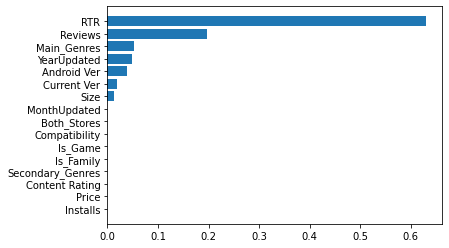

In [22]:
import matplotlib.pyplot as plt
from collections import OrderedDict

d={}
labels = []
sizes = []
for col, imp in zip(features, clf.feature_importances_):
    d[col]=imp

sort_d= {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
print(sort_d)

#Plot
plt.barh(*zip(*sort_d.items()))
plt.show()

- Evaluation metrics

In [23]:
print('MAE of TEST %s' %
      metrics.mean_absolute_error(y_test, y_pred))
print('\nMSE of TEST %s' %
      metrics.mean_squared_error(y_test, y_pred))
print('\nRMSE of TEST %s' %
      sqrt(mean_squared_error(y_test, y_pred)))

pearson_coef= stats.pearsonr(y_test, y_pred)
print("\nr TEST", pearson_coef[0])

ks= stats.ks_2samp(y_test, y_pred, alternative='two-sided', mode='auto')
print('\nKS TEST', ks[0])

MAE of TEST 0.342266179970681

MSE of TEST 0.24737844888356494

RMSE of TEST 0.49737154008202455

r TEST 0.3713370596488178

KS TEST 0.3033753558357056


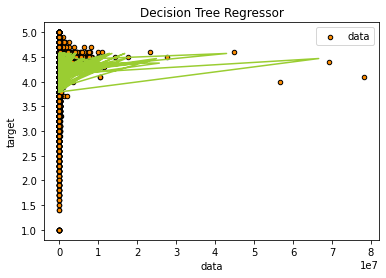

In [32]:
#DTR plot

plt.figure()
plt.scatter(np.array([item[0] for item in X_train.values]).reshape(X_train.shape[0],), y_train, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_pred, color="yellowgreen")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regressor")
plt.legend()
plt.show()

### Features selection

In [51]:
#Drop meaningless features

df_copy.drop(['Installs', 'Price', 'Content Rating', 'Secondary_Genres', 'Is_Family', 'Is_Game', 'Compatibility', 'Both_Stores', 'MonthUpdated', 'Current Ver', 'Size', 'Android Ver'], axis = 1, inplace=True) 

In [52]:
df_copy.head(2)

,Rating,Reviews,Main_Genres,RTR,YearUpdated
0,4.7,11661,17,0.002914,2018
1,4.0,19,42,0.000473,2017


In [53]:
features = [col for col in df_copy.columns if col != 'Rating']
X = df_copy[features].values

X = df_copy[features]
y = df_copy['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

### Hyper-parameters tuning

In [54]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [55]:
param_list = {"criterion": ["mse", "mae"],
              "min_samples_split": [2, 3, 4, 5, 6],
              "max_depth": [2, 5, 6, 7, 8, 10, 20],
              "min_samples_leaf": [5, 10, 50, 100, 200, 250],
              }, 

grid_search = GridSearchCV(clf, param_grid=param_list, cv=5, n_jobs=1)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_, n_top=3)

Mean validation score: 0.12804 (std: 0.01727)
Parameters: {'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 2}

Mean validation score: 0.12804 (std: 0.01727)
Parameters: {'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 3}

Mean validation score: 0.12804 (std: 0.01727)
Parameters: {'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 4}

Mean validation score: 0.12804 (std: 0.01727)
Parameters: {'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 5}

Mean validation score: 0.12804 (std: 0.01727)
Parameters: {'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 6}



In [56]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=8, min_samples_leaf=100, random_state=42)

### Perform best estimator and analyze the results

In [57]:
clf = grid_search.best_estimator_

y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

{'YearUpdated': 0.04854555425408849, 'Main_Genres': 0.16480976097693714, 'Reviews': 0.21155638157938464, 'RTR': 0.5750883031895896}


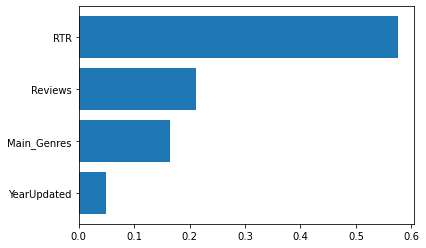

In [58]:
import matplotlib.pyplot as plt
from collections import OrderedDict

d={}
labels = []
sizes = []
for col, imp in zip(features, clf.feature_importances_):
    d[col]=imp

sort_d= {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
print(sort_d)

#Plot
plt.barh(*zip(*sort_d.items()))
plt.show()

In [59]:
print('MAE of TEST %s' %
      metrics.mean_absolute_error(y_test, y_pred))
print('\nMSE of TEST %s' %
      metrics.mean_squared_error(y_test, y_pred))
print('\nRMSE of TEST %s' %
      sqrt(mean_squared_error(y_test, y_pred)))

pearson_coef= stats.pearsonr(y_test, y_pred)
print("\nr TEST", pearson_coef[0])

ks= stats.ks_2samp(y_test, y_pred, alternative='two-sided', mode='auto')
print('\nKS TEST', ks[0])

MAE of TEST 0.34678322555147917

MSE of TEST 0.2503720327161822

RMSE of TEST 0.5003718944107295

r TEST 0.36043622133800524

KS TEST 0.2488816592110614


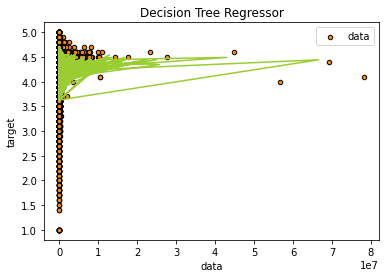

In [60]:
#DTR plot

plt.figure()
plt.scatter(np.array([item[0] for item in X_train.values]).reshape(X_train.shape[0],), y_train, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_pred, color="yellowgreen")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regressor")
plt.legend()
plt.show()

In [61]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [62]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=features,  
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=3)  
pydot_graph = pydotplus.graph_from_dot_data(dot_data)  
pydot_graph  = pydotplus.graph_from_dot_data(dot_data)  
pydot_graph.write_png('original_tree2.png')
pydot_graph.set_size('"10,10!"')
pydot_graph.write_png('resized_tree2.png')

True